In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150

# Loading in the Data

We saved the cleaned data to a file in the `data-cleaning` notebook, so let's load that data in.

In [2]:
data_file = Path("./data", "cleaned_data.hdf")
match_2018_train_df = pd.read_hdf(data_file, "train")

In [3]:
match_2018_train_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
1833,2018-7480,Cabo San Lucas,Hard,32,A,2018-07-30,289,111815,Cameron Norrie,L,...,5.0,2.0,4.0,64.0,27.0,20.0,14.0,9.0,6.0,10.0
2235,2018-0568,St. Petersburg,Hard,32,A,2018-09-17,299,106233,Dominic Thiem,R,...,1.0,1.0,2.0,61.0,38.0,25.0,12.0,9.0,6.0,8.0
1330,2018-520,Roland Garros,Clay,128,G,2018-05-28,198,106043,Diego Sebastian Schwartzman,R,...,5.0,4.0,5.0,111.0,69.0,46.0,14.0,0.0,10.0,16.0
2399,2018-M-DC-2018-G2-EPA-M-ROU-LUX-01,Davis Cup G2 R1: ROU vs LUX,Hard,4,D,2018-02-03,2,105657,Marius Copil,R,...,0.0,3.0,1.0,47.0,26.0,16.0,9.0,8.0,2.0,5.0
96,2018-0301,Auckland,Hard,32,A,2018-01-08,289,103970,David Ferrer,R,...,1.0,3.0,2.0,53.0,30.0,19.0,6.0,8.0,2.0,6.0


# Feature Selection / Engineering Part 1

Since we know both the winner's and loser's match information for each match, we can visualize their distributions to identify which features are strong in determining the winner of a match.

To standardize the match statistics, I convert them to percentages.

In [4]:
def convert_match_stats_to_percent(data):
    data['w_ace%'] = data['w_ace'] / data['w_svpt']
    data['l_ace%'] = data['l_ace'] / data['l_svpt']
    
    data['w_df%'] = data['w_df'] / data['w_svpt']
    data['l_df%'] = data['l_df'] / data['l_svpt']
    
    data['w_1stIn%'] = data['w_1stIn'] / data['w_svpt']
    data['l_1stIn%'] = data['l_1stIn'] / data['l_svpt']
    
    data['w_1stWon%'] = data['w_1stWon'] / data['w_1stIn']
    data['l_1stWon%'] = data['l_1stWon'] / data['l_1stIn']
    
    data['w_2ndWon%'] = data['w_2ndWon'] / (data['w_svpt'] - data['w_1stIn'])
    data['l_2ndWon%'] = data['l_2ndWon'] / (data['l_svpt'] - data['l_1stIn'])
    
    data['w_bpSaved%'] = data['w_bpSaved'] / data['w_bpFaced']
    data['l_bpSaved%'] = data['l_bpSaved'] / data['l_bpFaced']
    
    data['w_bpFaced%'] = data['w_bpFaced'] / data['w_svpt']
    data['l_bpFaced%'] = data['l_bpFaced'] / data['l_svpt']

convert_match_stats_to_percent(match_2018_train_df)

In [5]:
def plot_dist(winner_col_name, loser_col_name, stat_name):
    sns.distplot(match_2018_train_df[winner_col_name], hist=False, label=f"{stat_name} for winner")
    sns.distplot(match_2018_train_df[loser_col_name], hist=False, label=f"{stat_name} for loser")
    plt.title(f"Distribution of {stat_name}")
    plt.xlabel(f"{stat_name}")
    plt.legend()

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


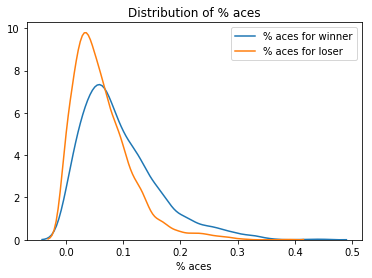

In [6]:
plot_dist('w_ace%', 'l_ace%', '% aces')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


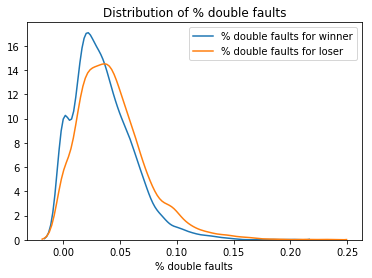

In [7]:
plot_dist('w_df%', 'l_df%', '% double faults')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


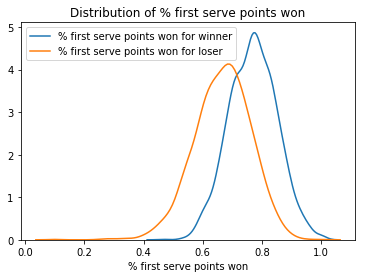

In [8]:
plot_dist('w_1stWon%', 'l_1stWon%', '% first serve points won')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


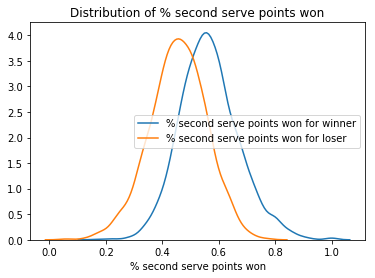

In [9]:
plot_dist('w_2ndWon%', 'l_2ndWon%', '% second serve points won')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


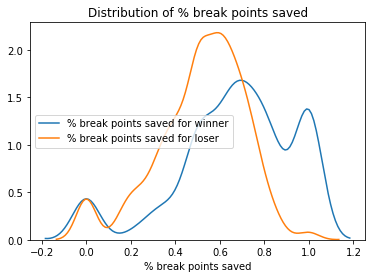

In [10]:
plot_dist('w_bpSaved%', 'l_bpSaved%', '% break points saved')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


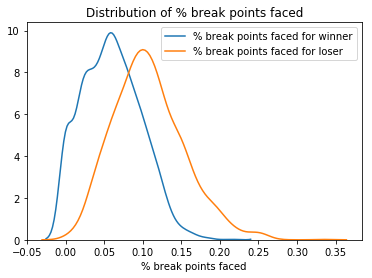

In [11]:
plot_dist('w_bpFaced%', 'l_bpFaced%', '% break points faced')

In any professional sport, especially professional tennis, the margin between victory and defeat is small. Therefore, I believe it is reasonable to say that if the difference between the peaks of the distribution of a match statistic for winners vs. losers is near 10% or above, then that match statistic is likely to be a good candidate for a strong feature in our model. Based on this reasoning, it seems the `% aces`, `% first serve points won`, and `% second serve points won` will likely be strong features. `% break points faced` may be a good feature, as the difference between the peaks of the distribution is around 5%. The distribution of `% break points saved` is not smooth due to undefined values when a player does not face a break point, but from domain knowledge I expect `% break points saved` to be a strong feature.

# Setting Up for Feature Engineering Part 2

## Filtering the Training Data

In general, training data has to consist of data representative of the same population as the input we are trying to make predictions about. In this context, what that means is if we are, for example, trying to predict the outcome of a match between Roger Federer and Rafael Nadal, our training data should consist of all matches played by Federer OR all matches played by Nadal. Therefore, each player in the dataset will have their own model that predicts their performance against an opponent. From this point forward, I will be constructing the model for Roger Federer to illustrate my thought process through developing the model.

In [12]:
def get_matches_for_player(data, player):
    """Returns a DataFrame containing all matches in DATA in which PLAYER played."""
    return data[(data['winner_name'] == player) | (data['loser_name'] == player)]

In [13]:
fed_2018 = get_matches_for_player(match_2018_train_df, "Roger Federer")
fed_2018.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,w_1stIn%,l_1stIn%,w_1stWon%,l_1stWon%,w_2ndWon%,l_2ndWon%,w_bpSaved%,l_bpSaved%,w_bpFaced%,l_bpFaced%
250,2018-580,Australian Open,Hard,128,G,2018-01-15,316,103819,Roger Federer,R,...,0.648936,0.677778,0.803279,0.672131,0.424242,0.413793,0.500000,0.375000,0.021277,0.088889
404,2018-0407,Rotterdam,Hard,32,A,2018-02-12,297,103819,Roger Federer,R,...,0.573770,0.657143,0.742857,0.608696,0.730769,0.375000,0.000000,0.375000,0.016393,0.114286
234,2018-580,Australian Open,Hard,128,G,2018-01-15,232,103819,Roger Federer,R,...,0.576087,0.504673,0.830189,0.759259,0.666667,0.509434,0.666667,0.727273,0.032609,0.102804
401,2018-0407,Rotterdam,Hard,32,A,2018-02-12,300,103819,Roger Federer,R,...,0.615385,0.591837,0.833333,0.620690,0.800000,0.450000,NaN,0.500000,0.000000,0.163265
264,2018-580,Australian Open,Hard,128,G,2018-01-15,602,103819,Roger Federer,R,...,0.432432,0.566038,0.937500,0.566667,0.714286,0.391304,1.000000,0.636364,0.027027,0.207547


In [14]:
match_stats = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
              'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']

def get_match_stats_for_player(data, player):
    """Returns a DataFrame of the data for match statistics in DATA that apply to PLAYER.
    For example, if PLAYER won match X, then the row in the returned DataFrame would
    contain the match statistics for match X that correspond to the winner, not the loser."""
    player_matches = get_matches_for_player(data, player)
    player_wins = player_matches[player_matches['winner_name'] == player]
    player_losses = player_matches[player_matches['loser_name'] == player]
    
    player_wins.drop(labels=match_stats[9:], axis=1, inplace=True)
    player_losses.drop(labels=match_stats[:9], axis=1, inplace=True)
    return player_losses

get_match_stats_for_player(match_2018_train_df, 'Roger Federer').columns

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_hand',
       'winner_ioc', 'winner_age', 'winner_rank', 'winner_rank_points',
       'loser_id', 'loser_name', 'loser_hand', 'loser_ioc', 'loser_age',
       'loser_rank', 'loser_rank_points', 'score', 'best_of', 'round',
       'minutes', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
       'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'w_ace%', 'l_ace%', 'w_df%',
       'l_df%', 'w_1stIn%', 'l_1stIn%', 'w_1stWon%', 'l_1stWon%', 'w_2ndWon%',
       'l_2ndWon%', 'w_bpSaved%', 'l_bpSaved%', 'w_bpFaced%', 'l_bpFaced%'],
      dtype='object')

## Adding a Variable to Predict

Since our ultimate goal is to predict the outcome of a match, we need to have a binary variable representing whether the match resulted in a win or a loss for a given player. This binary variable will the variable we will try to predict with our model.

In [15]:
def add_win_loss(data, player):
    data['result'] = data['winner_name'].apply(lambda w: 1 if w == player else 0)

In [16]:
add_win_loss(fed_2018, "Roger Federer")

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
fed_2018['result'].value_counts()

1    35
0     5
Name: result, dtype: int64

# Feature Engineering Part 2

There are other features which are not directly captured by the dataset that I believe will be useful in predicting the outcome of match.

## Win Streak

I define win streak as the number of consecutive wins a player has coming into the match whose outcome the model is attempting to predict. More specifically, the win streak is the number of consecutive wins a player has at the time when the training data ends, since the model makes predictions based off of training data.